## Домашнее задание  
### по теме «RF Regressor, Feature engineering» 

### Библиотеки

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from feature_engine.creation import MathFeatures


### Подготовка данных

In [2]:
# Загрузка данных
archive_path = 'data/train.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train.csv') as file:
        df = pd.read_csv(file)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df = df.drop(columns=['customer_feedback', 'policy_start_date'])

In [5]:
df = df.dropna()

In [6]:
df = df.sample(n=5000, random_state=42) 

In [7]:
# Корректировка выбросов по верхней границе
def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисление границы для каждого столбца
l_lower, l_upper = get_iqr_bounds(df['annual_income'])
df['annual_income'] = df['annual_income'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['premium_amount'])
df['premium_amount'] = df['premium_amount'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['previous_claims'])
df['previous_claims'] = df['previous_claims'].clip(upper=l_upper)

In [8]:
# Кодирование категориальных фичей
df = pd.get_dummies(df, columns=[
    'gender', 
    'marital_status', 
    'education_level',
    'occupation',
    'location',
    'policy_type',
    'smoking_status',
    'exercise_frequency',
    'property_type'],drop_first=True)

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5000.0,NaN,NaN,NaN,597189.1392,344271.693762,762.0,303449.75,592803.0,889932.75,1199693.0
age,5000.0,NaN,NaN,NaN,41.0992,13.566214,18.0,29.0,41.0,53.0,64.0
annual_income,5000.0,NaN,NaN,NaN,31958.9355,29631.894824,17.0,7695.25,23777.0,45163.0,101364.625
number_of_dependents,5000.0,NaN,NaN,NaN,2.0318,1.415906,0.0,1.0,2.0,3.0,4.0
health_score,5000.0,NaN,NaN,NaN,25.506605,12.146654,2.293558,15.950044,24.288681,34.471524,53.84682
previous_claims,5000.0,NaN,NaN,NaN,1.0316,0.997998,0.0,0.0,1.0,2.0,5.0
vehicle_age,5000.0,NaN,NaN,NaN,9.4838,5.844499,0.0,4.0,9.0,15.0,19.0
credit_score,5000.0,NaN,NaN,NaN,595.625,146.864819,300.0,476.0,598.0,718.0,849.0
insurance_duration,5000.0,NaN,NaN,NaN,5.0546,2.589471,1.0,3.0,5.0,7.0,9.0
premium_amount,5000.0,NaN,NaN,NaN,1104.2892,815.391715,20.0,522.0,889.0,1551.0,3094.5


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 678562 to 208907
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5000 non-null   int64  
 1   age                          5000 non-null   float64
 2   annual_income                5000 non-null   float64
 3   number_of_dependents         5000 non-null   float64
 4   health_score                 5000 non-null   float64
 5   previous_claims              5000 non-null   float64
 6   vehicle_age                  5000 non-null   float64
 7   credit_score                 5000 non-null   float64
 8   insurance_duration           5000 non-null   float64
 9   premium_amount               5000 non-null   float64
 10  gender_Male                  5000 non-null   bool   
 11  marital_status_Married       5000 non-null   bool   
 12  marital_status_Single        5000 non-null   bool   
 13  education_level_

### Выборки

In [11]:
# Подготовка данных
X = df.drop(['premium_amount','id'], axis=1)
y = df['premium_amount']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

### Подбор гиперпараметров

In [12]:
# Определяем сетку гиперпараметров
param_grid = {
    'n_estimators': [300, 500, 1000],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],   # Максимальная глубина дерева
    'min_samples_split': [2, 5],   # Минимальное количество образцов для разделения
    'min_samples_leaf': [4, 6],     # Минимальное количество образцов в листе
    'max_features': ['sqrt', 'log2']   # Количество признаков для поиска лучшего разделения
}

# Создаем модель
model = RandomForestRegressor(random_state=42)

# Инициализируем GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,                              
    n_jobs=-1,                        
    verbose=2                          
)

# Запускаем поиск по сетке
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Лучшая модель
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300}


### RandomForestRegressor на исходных данных

In [13]:
# fit
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      n_estimators=300, random_state=42)

In [14]:
# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')

MSE: 628204.30
MAE: 639.67
R²: 0.0177


Выводы:
- MSE (Mean Squared Error) = 628204.30 Очень высокое значение MSE указывает на то, что модель делает большие ошибки в предсказаниях.
- MAE (Mean Absolute Error) = 639.67 Высокое значение MAE подтверждает, что модель ошибается в предсказаниях.
- R² (Коэффициент детерминации) = 0.0177 Значение R² близко к 0, модель не объясняет целевую переменную.
- Модель не работает!

### Применение библиотеки feature-engine к набору данных

In [ ]:
# для генерации новых признаков путем математических операций
MF = MathFeatures(
    # Список признаков для комбинации
    # Беру связку самого важной фичи и таргет 
    # ===== ожидаю переобучение =====
    variables=["annual_income", "premium_amount"], 
    func=["sum", "min", "max", "std"]
)

# fit
MF.fit(df)

# Применение трансформации к данным
df_math = MF.transform(df)

### Изучение новых столбцо и удаление NaN и нулевых значений

In [16]:
df_math.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 678562 to 208907
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                5000 non-null   int64  
 1   age                               5000 non-null   float64
 2   annual_income                     5000 non-null   float64
 3   number_of_dependents              5000 non-null   float64
 4   health_score                      5000 non-null   float64
 5   previous_claims                   5000 non-null   float64
 6   vehicle_age                       5000 non-null   float64
 7   credit_score                      5000 non-null   float64
 8   insurance_duration                5000 non-null   float64
 9   premium_amount                    5000 non-null   float64
 10  gender_Male                       5000 non-null   bool   
 11  marital_status_Married            5000 non-null   bool   
 12  mari

Генерированно 4 новых столбца

In [17]:
df_new = df_math[[
    'sum_annual_income_premium_amount',
    'min_annual_income_premium_amount',
    'max_annual_income_premium_amount', 
    'std_annual_income_premium_amount'
]]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 678562 to 208907
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   sum_annual_income_premium_amount  5000 non-null   float64
 1   min_annual_income_premium_amount  5000 non-null   float64
 2   max_annual_income_premium_amount  5000 non-null   float64
 3   std_annual_income_premium_amount  5000 non-null   float64
dtypes: float64(4)
memory usage: 195.3 KB


In [18]:
df_new.describe(include='all')

,sum_annual_income_premium_amount,min_annual_income_premium_amount,max_annual_income_premium_amount,std_annual_income_premium_amount
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,33063.224700,1068.862000,31994.362700,21867.631257
std,29666.947024,793.962764,29595.515575,20891.650154
min,70.000000,17.000000,45.000000,0.000000
25%,8585.500000,511.000000,7695.250000,4700.138775
50%,24707.500000,854.000000,23777.000000,16155.268630
75%,46224.250000,1489.000000,45163.000000,31231.669088
max,104459.125000,3094.500000,101364.625000,71661.471574


In [19]:
nan_columns = df_new.columns[df_new.isna().any()].tolist()
print("Столбцы с NaN:", nan_columns)

Столбцы с NaN: []


In [20]:
zero_percentage = (df_new == 0).mean() * 100
print("Доля нулей (%):")
print(zero_percentage)

Доля нулей (%):
sum_annual_income_premium_amount    0.00
min_annual_income_premium_amount    0.00
max_annual_income_premium_amount    0.00
std_annual_income_premium_amount    0.06
dtype: float64


В новых столбцах нулей и пропусков нет

### Обучение на генерированных данных

In [21]:
# Подготовка данных
X = df_math.drop(['premium_amount','id'], axis=1)
y = df_math['premium_amount']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Обучаю на тех же гиперпараметрах
best_model_math = grid_search.best_estimator_

# fit
best_model_math.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = best_model_math.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')

MSE: 75083.31
MAE: 190.99
R²: 0.8826


### Выводы по новой модели
- Значительно снизилось MSE с 628204.30 до 75083.31
- MAE снизилось с 639.67 до 190.99
- R² выросло с 0.0177 до 0.8826
- модель показывает значительное улучшение метрик

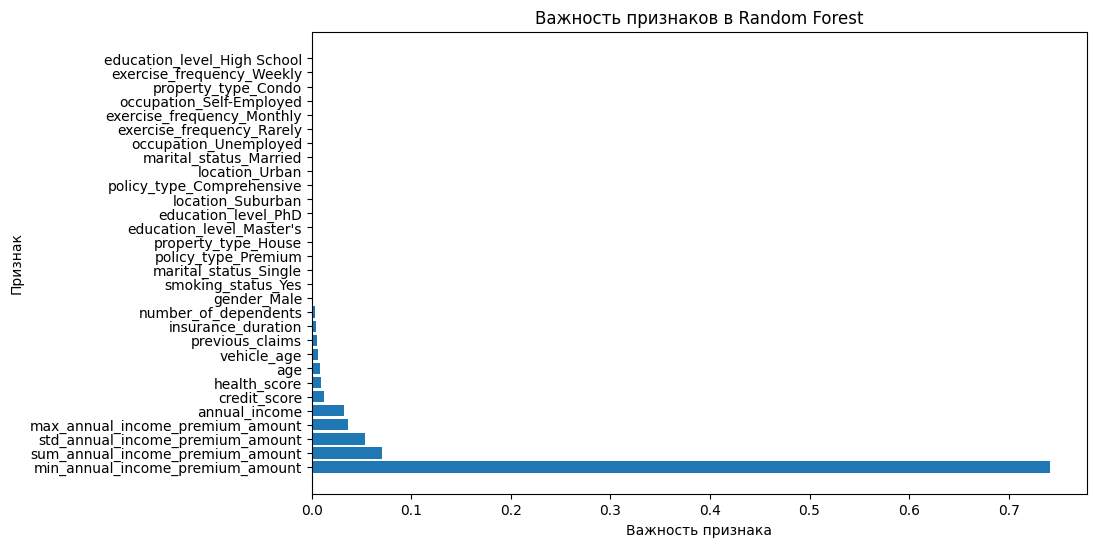

In [22]:
# Важность признаков
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values("Importance", ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков в Random Forest")
plt.show()

In [23]:
# Получаем важность признаков
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values("Importance", ascending=False)

# Топ-10 признаков
top_10 = feature_importance.head(10)
top_10

,Feature,Importance
27,min_annual_income_premium_amount,0.741583
26,sum_annual_income_premium_amount,0.070313
29,std_annual_income_premium_amount,0.053765
28,max_annual_income_premium_amount,0.035990
1,annual_income,0.032295
6,credit_score,0.012201
3,health_score,0.009109
0,age,0.007741
5,vehicle_age,0.005690
4,previous_claims,0.005375


- Все 4 новых фичи вошли в ТОП-10
- 'min_annual_income_premium_amount' значительно опережает остальные параметры по важности.

### Проверка на переобучение


Проверка на переобучение:
Train R²: 0.9092 | Test R²: 0.8826
Train MSE: 60929.66 | Test MSE: 75083.31

Разница между train и test:
R² difference: 0.0266
MSE relative difference: 23.2%

Признаки переобучения:
- Большая разница в MSE (23% > 20%)


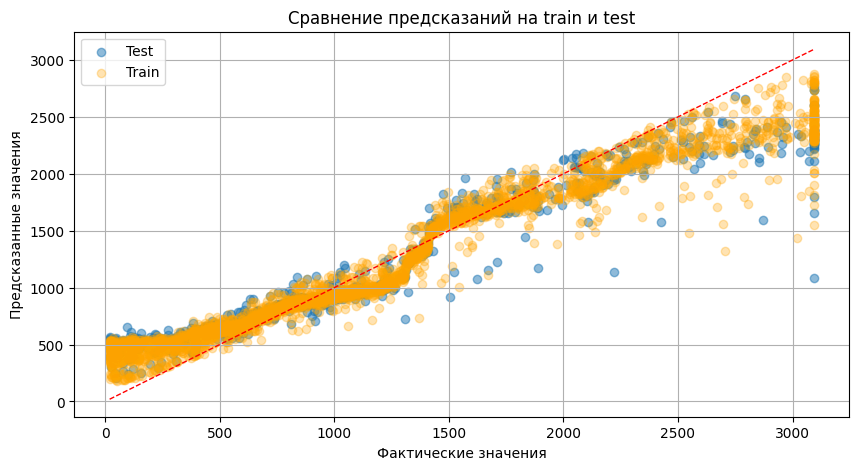

In [24]:
# В домашнем задании нет такой задачи делаю ради интереса
train_pred = best_model_math.predict(X_train)
test_pred = best_model_math.predict(X_test)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print("\nПроверка на переобучение:")
print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}")

r2_diff = abs(train_r2 - test_r2)
mse_diff = abs(train_mse - test_mse)/train_mse

print(f"\nРазница между train и test:")
print(f"R² difference: {r2_diff:.4f}")
print(f"MSE relative difference: {mse_diff:.1%}")

if r2_diff > 0.15 or mse_diff > 0.2:
    print("\nПризнаки переобучения:")
    if r2_diff > 0.15:
        print(f"- Большая разница в R² ({r2_diff:.2f} > 0.15)")
    if mse_diff > 0.2:
        print(f"- Большая разница в MSE ({mse_diff:.0%} > 20%)")
else:
    print("\nПризнаков переобучения не обнаружено")

# График
plt.figure(figsize=(10, 5))
plt.scatter(y_test, test_pred, alpha=0.5, label='Test')
plt.scatter(y_train, train_pred, alpha=0.3, label='Train', color='orange')
plt.plot([min(y), max(y)], [min(y), max(y)], '--r', linewidth=1)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний на train и test')
plt.legend()
plt.grid(True)
plt.show()

Новая модель с генерированными параметрами имеет признаки переобучения.

## Вводы по домашней работе
- Feature engineering помогает улучшить качество моделей
- Инструменты автоматизации позволяют ускорить процесс создания новых параметров
- В любом случае требуется детальный анализ генерированных параметров и изучение предметной области